# [GDCV]3rd_Project-Object_detection
***
## 1. 데이터 셋 준비
## 2. 모델 훈련
## 3. 추론 및 시각화 확인
## 4. "Go" and "Stop" 설계하기
***

## 1. 데이터 셋 준비하기

      tensorflow_datasets에서 제공하는 KITTI 데이터셋을 사용합니다. KITTI 데이터셋은 자율주행을 위한 데이터셋으로 2D objecte detection 뿐만 아니라 깊이까지 포함한 3D object detection 라벨 등을 제공하고 있습니다.

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image, ImageDraw

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
# 다운로드에 매우 긴 시간이 소요됩니다. 
import urllib3
urllib3.disable_warnings()
(ds_train, ds_test), ds_info = tfds.load(
    'kitti',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

      데이터 포멧을 변경해줍니다. tensorflow_dataset의 API를 사용해 이미지와 각 이미지에 해당하는 바운딩 박스 라벨의 정보를 얻을 수 있습니다. API를 활용하여 데이터를 추출, 이를 포맷팅 하여 CSV 형태로 한 줄씩 저장합니다.

In [4]:
import os
data_dir = os.getenv('HOME')+'/aiffel/object_detection/data'
img_dir = os.getenv('HOME')+'/kitti_images'
train_csv_path = data_dir + '/kitti_train.csv'

# parse_dataset 함수를 구현해 주세요.
def parse_dataset(dataset, img_dir="kitti_images", total=0):
    if not os.path.exists(img_dir):
        os.mkdir(img_dir)
    # Dataset의 claas를 확인하여 class에 따른 index를 확인해둡니다.
    # 저는 기존의 class를 차와 사람으로 나누었습니다.
    type_class_map = {
        0: "car",
        1: "car",
        2: "car",
        3: "person",
        4: "person",
        5: "person",
    }
    # Keras retinanet을 학습하기 위한 dataset을 csv로 parsing하기 위해서 필요한 column을 가진 pandas.DataFrame을 생성합니다.
    df = pd.DataFrame(columns=["img_path", "x1", "y1", "x2", "y2", "class_name"])
    for item in tqdm(dataset, total=total):
        filename = item['image/file_name'].numpy().decode('utf-8')
        img_path = os.path.join(img_dir, filename)

        img = Image.fromarray(item['image'].numpy())
        img.save(img_path)
        object_bbox = item['objects']['bbox']
        object_type = item['objects']['type'].numpy()
        width, height = img.size

        # tf.dataset의 bbox좌표가 0과 1사이로 normalize된 좌표이므로 이를 pixel좌표로 변환합니다.
        x_min = object_bbox[:,1] * width
        x_max = object_bbox[:,3] * width
        y_min = height - object_bbox[:,2] * height
        y_max = height - object_bbox[:,0] * height

        # 한 이미지에 있는 여러 Object들을 한 줄씩 pandas.DataFrame에 append합니다.
        rects = np.stack([x_min, y_min, x_max, y_max], axis=1).astype(np.int)
        for i, _rect in enumerate(rects):
            _type = object_type[i]
            if _type not in type_class_map.keys():
                continue
            df = df.append({
                "img_path": img_path,
                "x1": _rect[0],
                "y1": _rect[1],
                "x2": _rect[2],
                "y2": _rect[3],
                "class_name": type_class_map[_type]
            }, ignore_index=True)
            break
    return df

df_train = parse_dataset(ds_train, img_dir, total=ds_info.splits['train'].num_examples)
df_train.to_csv(train_csv_path, sep=',',index = False, header=False)

100%|██████████| 6347/6347 [13:30<00:00,  7.84it/s]


      테스트 데이터 셋에도 동일한 과정을 진행해줍니다.

In [5]:
test_csv_path = data_dir + '/kitti_test.csv'

df_test = parse_dataset(ds_test, img_dir, total=ds_info.splits['test'].num_examples)
df_test.to_csv(test_csv_path, sep=',',index = False, header=False)

100%|██████████| 711/711 [01:35<00:00,  7.47it/s]


      데이터셋에서 클래스는 문자열(string)으로 표시되지만, 모델에게 데이터를 알려줄 때에는 숫자를 사용해 클래스를 표시해야 합니다. 이때 모두 어떤 클래스가 있고 각 클래스가 어떤 인덱스(index)에 맵핑(mapping)될지 미리 정하고 저장해 두어야 학습을 한 후 추론(inference)을 할 때에도 숫자 인덱스로 나온 정보를 클래스 이름으로 바꾸어 해석할 수 있습니다.

In [6]:
class_txt_path = data_dir + '/classes.txt'

def save_class_format(path="./classes.txt"):
    class_type_map = {
        "car" : 0,
        "person": 1
    }
    with open(path, mode='w', encoding='utf-8') as f:
        for k, v in class_type_map.items():
            f.write(f"{k},{v}\n")

save_class_format(class_txt_path)

## 2. 모델 훈련

      케라스 및 Keras RetinaNet 리포지토리를 사용합니다.

In [7]:
# RetinaNet 훈련이 시작됩니다!! 50epoch 훈련에 1시간 이상 소요될 수 있습니다. 
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/train.py --gpu 0 --multiprocessing --workers 4 --batch-size 2 --epochs 50 --steps 195 csv data/kitti_train.csv data/classes.txt

2021-04-27 05:51:20.823209: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 05:51:22.039566: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 05:51:22.062832: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 05:51:22.063342: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 05:51:22.063364: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 05:51:22.065527: I tensorflow/stream_executor/platform

      아래 코드를 사용해 학습된 모델을 추론을 위해 실행할 수 있는 케라스 모델로 변환합니다.

In [8]:
!cd ~/aiffel/object_detection && python keras-retinanet/keras_retinanet/bin/convert_model.py snapshots/resnet50_csv_50.h5 snapshots/resnet50_csv_50_infer.h5

2021-04-27 06:42:02.137841: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 06:42:03.544868: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-04-27 06:42:03.566787: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-27 06:42:03.567216: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: GeForce RTX 2070 computeCapability: 7.5
coreClock: 1.455GHz coreCount: 36 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 327.88GiB/s
2021-04-27 06:42:03.567238: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-04-27 06:42:03.569554: I tensorflow/stream_executor/platform

## 3. 추론 및 시각화 확인

      위에서 학습을 완료하고 변환까지 마친 모델을 이용하여 추론 및 시각화를 확인합니다. 0.5 미만의 점수를 가진 객체들은 제외합니다.

In [9]:
%matplotlib inline

# automatically reload modules when they have changed
%load_ext autoreload
%autoreload 2

# import keras
import keras

# import keras_retinanet
from keras_retinanet import models
from keras_retinanet.models import load_model
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color
from keras_retinanet.utils.gpu import setup_gpu

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

gpu = '0'
setup_gpu(gpu)

dir_path = os.getenv('HOME') + '/aiffel/object_detection/'
model_path = os.path.join(dir_path, 'snapshots', 'resnet50_csv_49_infer.h5')
model = load_model(model_path, backbone_name='resnet50')

Physical devices cannot be modified after being initialized
1 Physical GPUs, 1 Logical GPUs


      자동차는 파랑색, 사람은 빨간색 사각형으로 표시합니다. 사각형 상단엔 해당 객체의 점수를 표기합니다. 아래서 사용한 이미지는 각각 0.678, 0.673을 가지고 있습니다.

[593.8516  176.21365 625.2919  205.82323]
31.440247
29.609573
[188.20357 131.0855  356.64938 232.82394]


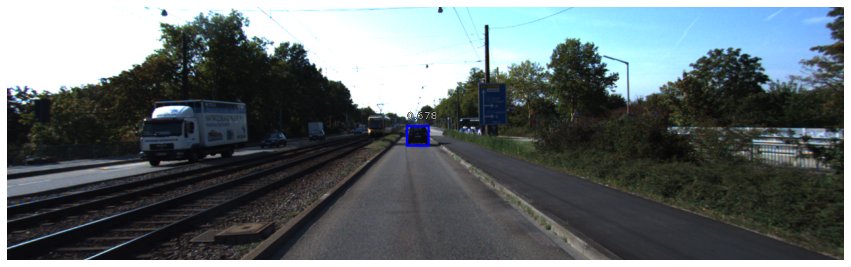

In [22]:
import os
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'

# inference_on_image 함수를 구현해 주세요.
def inference_on_image(model, img_path="./test_set/go_1.png", visualize=True):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale

    # display images
    if  visualize:
        for box, score, label in zip(boxes[0], scores[0], labels[0]):
            print(box)
            if score < 0.5:
                break
            b = box.astype(int)
            draw_box(draw, b, color=color_map[label])
            
            print(box[2]-box[0])
            print(box[3]-box[1])
            
            caption = "{:.3f}".format(score)
            draw_caption(draw, b, caption)

        plt.figure(figsize=(15, 15))
        plt.axis('off')
        plt.imshow(draw)
        plt.show()            

inference_on_image(model, img_path=img_path)

[769.5885  148.0789  847.46576 316.44424]
[772.1842  147.59842 847.8338  312.662  ]


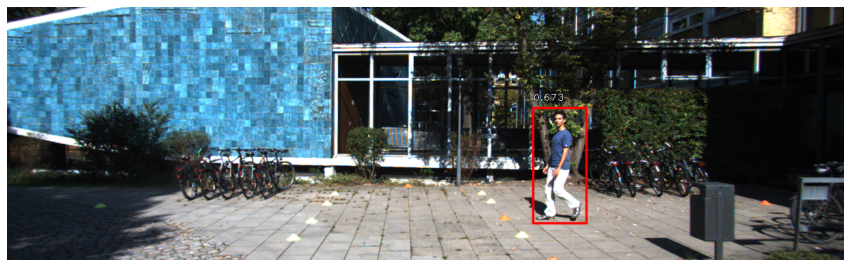

In [11]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
inference_on_image(model, img_path=img_path)

      확인해야할 테스트 셋의 이미지들 불러와서 객체들을 확인합니다. 이때, 사각형의 가로와 세로 길이를 분류할 때 기준으로 사용하기 위해서 표기해줍니다.

In [ ]:
img_path0 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'
img_path1 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_2.png'
img_path2 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_3.png'
img_path3 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_4.png'
img_path4 = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_5.png'
img_path5 = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_1.png'
img_path6 = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_2.png'
img_path7 = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_3.png'
img_path8 = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_4.png'
img_path9 = os.getenv('HOME')+'/aiffel/object_detection/test_set/go_5.png'

[769.5885  148.0789  847.46576 316.44424]
77.87726
168.36534
[772.1842  147.59842 847.8338  312.662  ]


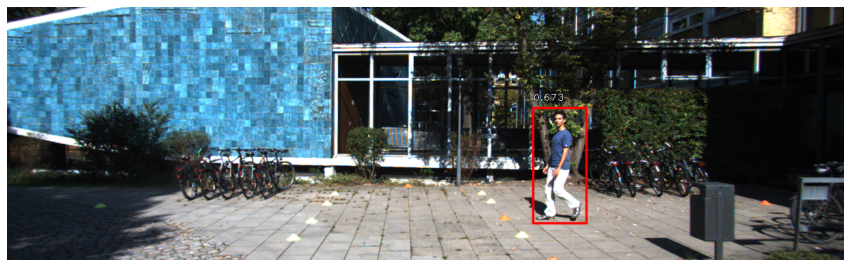

[413.0601  164.64192 499.56177 336.03076]
86.50168
171.38884
[419.8434  162.76607 497.7006  329.35654]


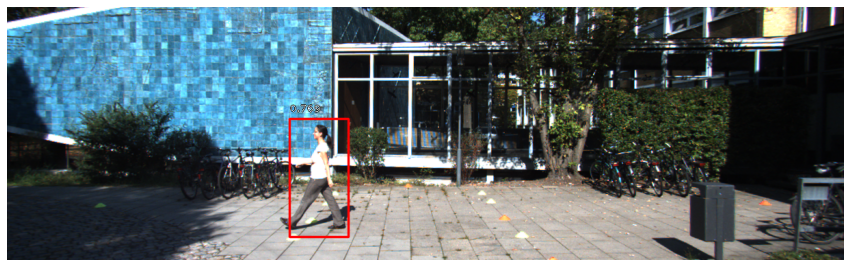

[  0.      203.06949 308.18805 367.71487]
308.18805
164.64539
[751.2683  161.46104 881.0231  208.49342]


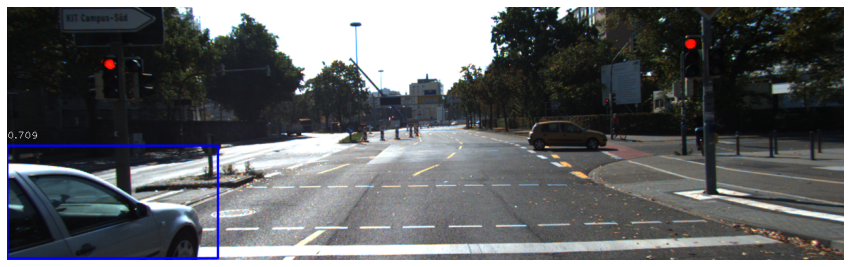

[ 720.7489    39.83124 1101.3611   362.21948]
380.61218
322.38824
[ 19.215015 163.54944  352.05994  338.94736 ]


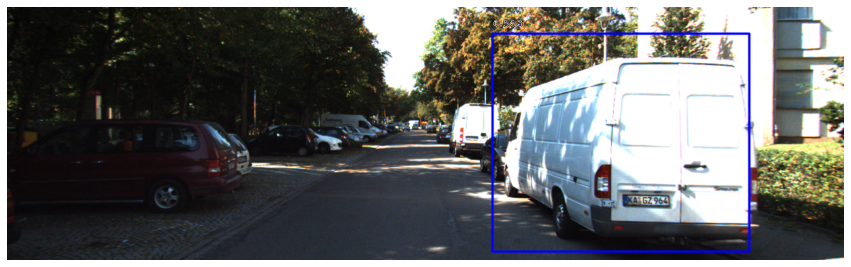

[ 880.1932   175.43295 1230.7158   373.2152 ]
350.52264
197.78226
[732.35944 164.6255  856.35266 243.87076]


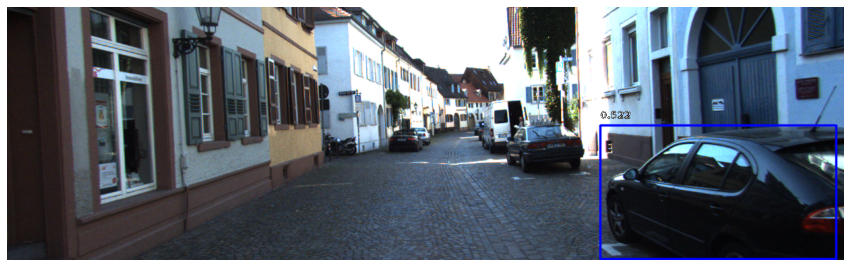

[593.8516  176.21365 625.2919  205.82323]
31.440247
29.609573
[188.20357 131.0855  356.64938 232.82394]


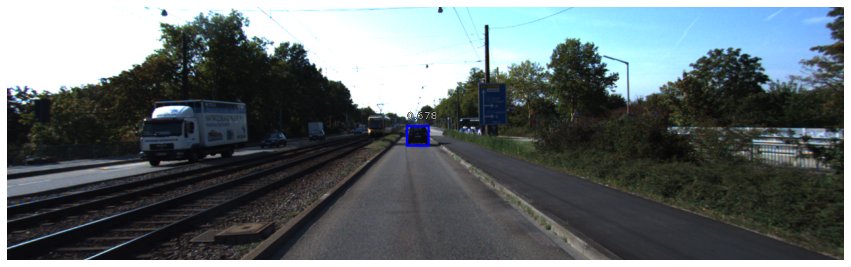

[625.78094 174.18004 666.2393  213.0285 ]
40.458374
38.848465
[611.16724 171.45787 675.89496 221.54669]


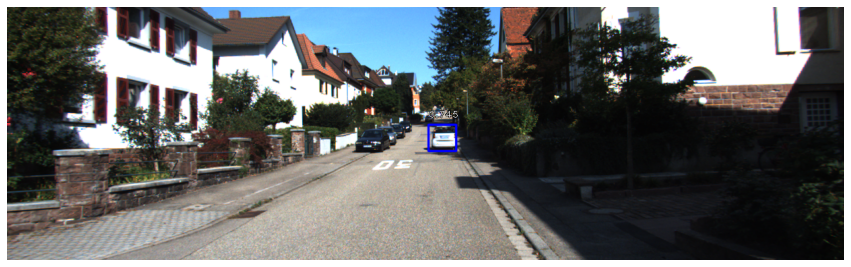

[810.40173 141.80547 890.22046 176.439  ]


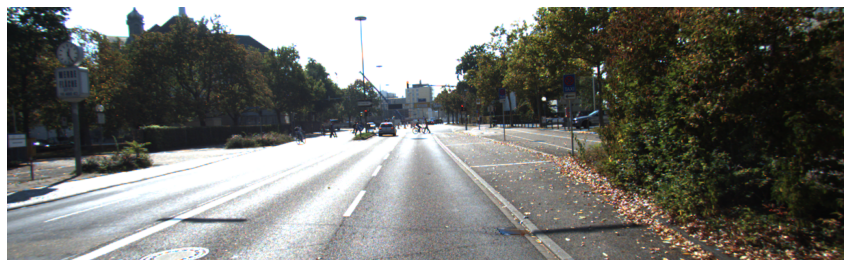

[694.1888  169.36838 789.72034 249.87466]


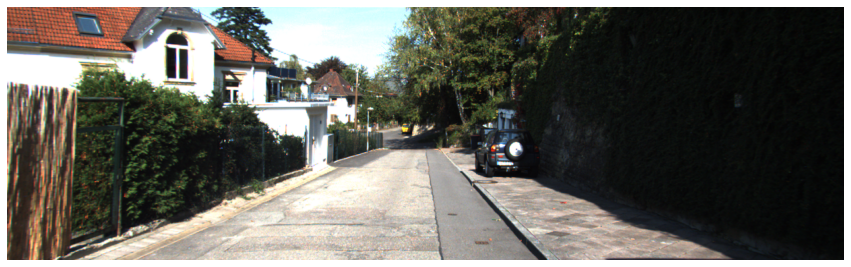

[ 11.133945 186.79018  181.10712  317.2762  ]


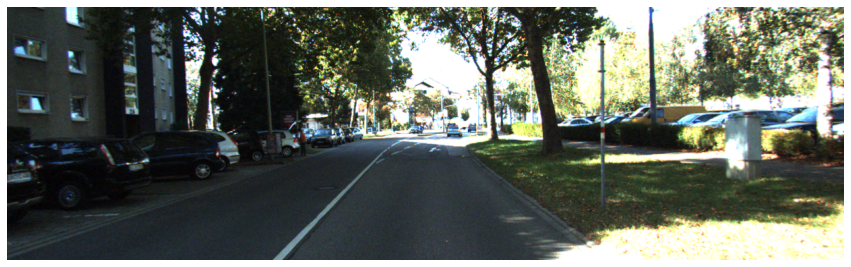

In [23]:
inference_on_image(model, img_path=img_path0)
inference_on_image(model, img_path=img_path1)
inference_on_image(model, img_path=img_path2)
inference_on_image(model, img_path=img_path3)
inference_on_image(model, img_path=img_path4)
inference_on_image(model, img_path=img_path5)
inference_on_image(model, img_path=img_path6)
inference_on_image(model, img_path=img_path7)
inference_on_image(model, img_path=img_path8)
inference_on_image(model, img_path=img_path9)

      확인 결과, "Go"를 가진 사진들 중 객체를 가지고 있는 경우 사각형의 한 변이 대략 50미만을 가지고 있음을 확인할 수 있었습니다.

## 4. "Go" and "Stop" 설계하기

      이제 "Go"와 "Stop"을 판별하기 위한 함수를 설계합니다.
      
      0.5점 미만인 객체를 가진 이미지의 경우 "Go"를 리턴합니다.
      label이 1인, 즉 사람인 객체가 있는 이미지의 경우 "Stop"을 리턴합니다.
      label이 0이고 0.5점 이상인 객체를 가진 이미지의 경우, 사각형 변들의 길이를 이용하여 50미만을 경우 충분히 멀다고 판단하고 "Go"를 리턴해주고 그 외의 경우엔 "Stop"를 리턴해줍니다.

In [36]:
img_path = os.getenv('HOME')+'/aiffel/object_detection/test_set/stop_1.png'

def self_drive_assist(img_path, size_limit=300):
    # 코드 구현
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    color_map = {
        0: (0, 0, 255), # blue
        1: (255, 0, 0) # red
    }

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))

    # correct for image scale
    boxes /= scale
    
    # 정지조건에 맞으면 return "Stop"
    # 아닌 경우 return "Go"

    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        if score < 0.5:
            return "Go"
        
        if label == 1:
            return "Stop"
            
        if label == 0:
            if box[2]-box[0] < 50 or box[3]-box[1] < 50:
                return "Go"
            else:
                return "Stop"
    
print(self_drive_assist(img_path))    

Stop


In [37]:
print(self_drive_assist(img_path0))   
print(self_drive_assist(img_path1))   
print(self_drive_assist(img_path2))   
print(self_drive_assist(img_path3))   
print(self_drive_assist(img_path4))   
print(self_drive_assist(img_path5))   
print(self_drive_assist(img_path6))   
print(self_drive_assist(img_path7))   
print(self_drive_assist(img_path8))   
print(self_drive_assist(img_path9))   

Stop
Stop
Stop
Stop
Stop
Go
Go
Go
Go
Go


In [38]:
import os

def test_system(func):
    work_dir = os.getenv('HOME')+'/aiffel/object_detection'
    score = 0
    test_set=[
        ("test_set/stop_1.png", "Stop"),
        ("test_set/stop_2.png", "Stop"),
        ("test_set/stop_3.png", "Stop"),
        ("test_set/stop_4.png", "Stop"),
        ("test_set/stop_5.png", "Stop"),
        ("test_set/go_1.png", "Go"),
        ("test_set/go_2.png", "Go"),
        ("test_set/go_3.png", "Go"),
        ("test_set/go_4.png", "Go"),
        ("test_set/go_5.png", "Go"),
    ]

    for image_file, answer in test_set:
        image_path = work_dir + '/' + image_file
        pred = func(image_path)
        if pred == answer:
            score += 10
    print(f"{score}점입니다.")

test_system(self_drive_assist)

100점입니다.


      100점으로 성공적으로 분류했음을 확인했습니다.

*********************************************************************
# 결론 및 감상

      데이터를 가공하고 학습을 진행한 후, 모델을 이용하여 성공적으로 바운딩 박스를 그려내는데 성공하였다.
      
      이후 "Go"와 "Stop"을 판별하는 함수를 설계할 때, label이 1이면 무조건 "Stop"으로 점수가 0.5 미만이면 무조건 "Go"로 리턴하게 설계하였더니 70점으로 낮은 성공률이 나오는 것을 확인하고 분류에 실패한 이미지를 찾아보니 테스트 셋의 "Go" 이미지 첫번째와 두번째에서 객체가 매우 작게 잡혀서 멀리 있음에도 무조건 "Stop"로 나오는 것을 확인하고 사각형 변의 길이를 이용하여 다시 한번 분류하게 설계하였더니 성공적으로 분류하였다.
      
       좀 더 다양한 조건을 이용하여 "Go"와 "Stop"을 분류하게 설계하면 다양한 장애물과 요소들이 있어도 성공적으로 분류할 수 있는 모델과 함수를 설계할 수 있을 것 같다.